In [21]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools import DuckDuckGoSearchResults

In [22]:
llm=ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    api_key=os.getenv("GOOGLE_API_KEY"),
)

Tools

In [23]:
tools=[DuckDuckGoSearchResults()]
tool_dict={tool.name:tool for tool in tools}
llm_with_tools=llm.bind_tools(tools)

Graph State

In [24]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict,Annotated
import operator

class MessagesState(TypedDict):
    messages:Annotated[list[AnyMessage],operator.add]
    llm_calls:int

In [25]:
from langchain_core.messages import SystemMessage

def llm_call(state: dict):
    '''LLM decides whether to call a tool or not'''

    # Filter out any unexpected keys, only use 'messages' and 'llm_calls'
    messages = state.get('messages', [])
    llm_calls = state.get('llm_calls', 0)

    output = {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant who will answer any query related to finance. Return ""I Cannot Answer That"" if it is out of scope. Do NOT provide sensitive information"
                    )
                ] + messages
            ),
        ],
        "llm_calls": llm_calls + 1
    }

    return output


In [26]:
from langchain_core.messages import ToolMessage

def tool_node(state:dict):
    '''Performs the tool call'''

    result=[]
    for tool_call in state['messages'][-1].tool_calls:
        tool=tool_dict[tool_call['name']]
        observation=tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation,
                      tool_call_id=tool_call['id']))
        
    return {"messages":result}


In [27]:
from typing import Literal
from langgraph.graph import StateGraph,START,END

def should_continue(state: MessagesState)->Literal["Information Retrieval",END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages=state['messages']
    last_message=messages[-1]

    if(last_message.tool_calls):
        return "Information Retrieval"
    return END

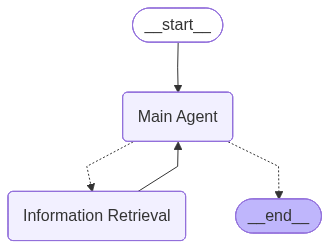

In [28]:
agent_builder=StateGraph(MessagesState)

agent_builder.add_node("Main Agent",llm_call)
agent_builder.add_node("Information Retrieval",tool_node)

agent_builder.add_edge(START,"Main Agent")
agent_builder.add_conditional_edges(
    "Main Agent",
    should_continue,
    ["Information Retrieval",END]
)

agent_builder.add_edge("Information Retrieval","Main Agent")

agent=agent_builder.compile()

from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))


Chat

In [29]:
from langchain_core.messages import HumanMessage

In [30]:
inp=str("Hi")

while inp.lower()!="exit":
    message = [HumanMessage(content=inp)]
    response=agent.invoke({"messages": message})

    for m in response["messages"]:
        m.pretty_print()
    
    inp=str(input("Ask A Question:"))

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello! How can I help you with your financial questions today?
================================ Human Message =================================

What is the difference between options and futures?
================================== Ai Message ==================================

[{'type': 'text', 'text': 'Options and futures are both financial derivatives, meaning their value is derived from an underlying asset, but they have key differences:\n\n**Options:**\n*   **Right, Not Obligation:** An option gives the buyer the *right*, but not the *obligation*, to buy (call option) or sell (put option) an underlying asset at a predetermined price (strike price) on or before a specific date (expiration date).\n*   **Premium:** The buyer pays a premium to the seller for this right.\n*   **Limited Risk for Buyer:** The maximum loss f